In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

np.random.seed(0)

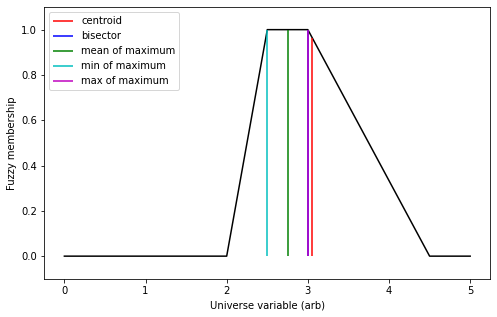

In [2]:
# Generate trapezoidal membership function on range [0, 1]
x = np.arange(0, 5.05, 0.1)
mfx = fuzz.trapmf(x, [2, 2.5, 3, 4.5])

# Defuzzify this membership function five ways
defuzz_centroid = fuzz.defuzz(x, mfx, 'centroid')  # Same as skfuzzy.centroid
defuzz_bisector = fuzz.defuzz(x, mfx, 'bisector')
defuzz_mom = fuzz.defuzz(x, mfx, 'mom')
defuzz_som = fuzz.defuzz(x, mfx, 'som')
defuzz_lom = fuzz.defuzz(x, mfx, 'lom')

# Collect info for vertical lines
labels = ['centroid', 'bisector', 'mean of maximum', 'min of maximum',
          'max of maximum']
xvals = [defuzz_centroid,
         defuzz_bisector,
         defuzz_mom,
         defuzz_som,
         defuzz_lom]
colors = ['r', 'b', 'g', 'c', 'm']
ymax = [fuzz.interp_membership(x, mfx, i) for i in xvals]

# Display and compare defuzzification results against membership function
plt.figure(figsize=(8, 5))

plt.plot(x, mfx, 'k')
for xv, y, label, color in zip(xvals, ymax, labels, colors):
    plt.vlines(xv, 0, y, label=label, color=color)
plt.ylabel('Fuzzy membership')
plt.xlabel('Universe variable (arb)')
plt.ylim(-0.1, 1.1)
plt.legend(loc=2)

plt.show()

In [3]:
def coh_high(x, s_c=0.3):
    return 1 / (1 + np.exp(-s_c * x))

def adh_high(x, A_max, s_ah=0.3):
    return np.exp( ( (-x**2) / 2*((A_max*s_ah)**2) ) )

def adh_low(x, A_max, s_al=0.27):
    res = (-(x-A_max)**2) / 2*((A_max*s_al)**2)
    return np.exp(res)  

In [9]:
from skfuzzy import control as ctrl
from skfuzzy import membership as mb

#Create test data: A_max the right boundary [0, A_max] for the fuzzy membership functions
A_max = 1.01
a = np.arange(0, A_max, 0.01)
k = np.linspace(0, 5, 10)
# r = np.random.rand(100)
# print(k, '\n', r)
# coh_high = adh_high(k, A_max)
# print(coh_high)

coh = ctrl.Antecedent(a, 'cohesion')
adh = ctrl.Antecedent(a, 'adhesion')
wei = ctrl.Consequent(a, 'weight')

# coh.automf(3)
# adh.automf(3)
# Define the membership functions & populate the space
coh['high'] = coh_high(coh.universe)
adh['low'] = adh_low(adh.universe, A_max)
adh['high'] = adh_high(adh.universe, A_max)

# construct triangular output/weight member functions.
wei['low'] = fuzz.trimf(wei.universe, [0, 0, 0.13])
wei['average'] = fuzz.trimf(wei.universe, [0.16, 0.33, 0.5])
wei['high'] = fuzz.trimf(wei.universe, [0.6, 1.01, 1.01])

c:\Users\trantasa\Desktop\MCS_Projects\Surrogating\FLOLA_CODE\flola\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


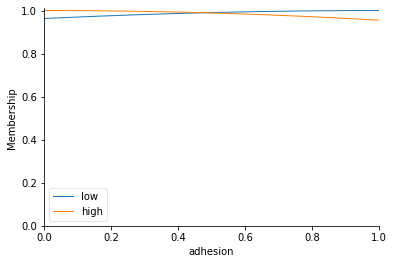

In [10]:
adh.view()
# coh.view()

centroid


c:\Users\trantasa\Desktop\MCS_Projects\Surrogating\FLOLA_CODE\flola\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


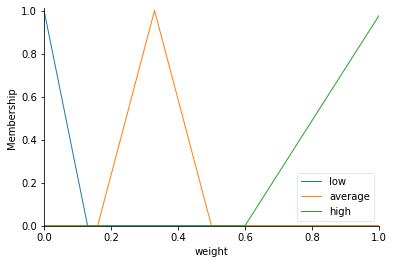

In [11]:
wei.view()
print(wei.defuzzify_method)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

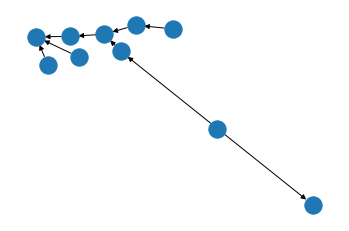

In [12]:
#Define the rules of the System 
rule1 = ctrl.Rule(coh['high'] & adh['low'], wei['high'])
rule2 = ctrl.Rule(coh['high'] & adh['high'], wei['average'])
rule3 = ctrl.Rule(~coh['high'] & adh['low'], wei['average'])
rule4 = ctrl.Rule(~coh['high'] & adh['high'], wei['low'])

rule1.view()

In [13]:
FLOLA_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])

In [14]:
flola_sim1 = ctrl.ControlSystemSimulation(FLOLA_ctrl)

In [15]:
flola_sim1.input['cohesion'] = 0.9
flola_sim1.input['adhesion'] = 0.2
flola_sim1.compute()

0.5382339094439905


c:\Users\trantasa\Desktop\MCS_Projects\Surrogating\FLOLA_CODE\flola\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


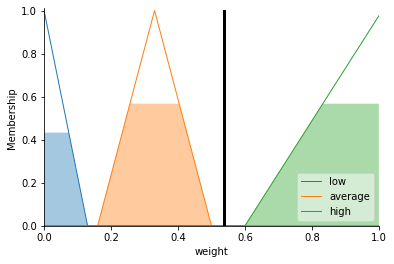

In [16]:
print(flola_sim1.output['weight'])

wei.view(sim=flola_sim1)

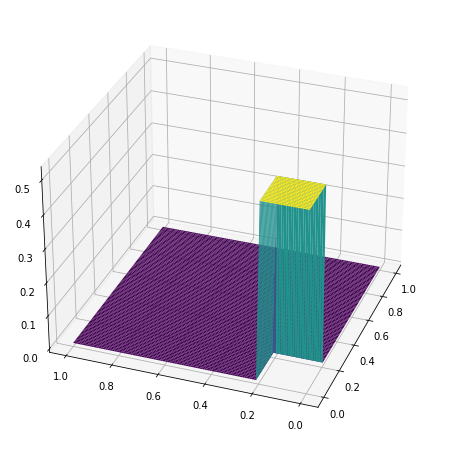

In [17]:
ups = np.arange(0, A_max, 0.01)
# ups = np.linspace(0,10,21)
x, y = np.meshgrid(ups, ups)
z = np.zeros_like(x)
# Loop through the system 21*21 times to collect the control surface
for i in range(21):
    for j in range(21):
        flola_sim1.input['cohesion'] = x[i, j]
        flola_sim1.input['adhesion'] = y[i, j]
        flola_sim1.compute()
        z[i, j] = flola_sim1.output['weight']

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)